In [66]:
from google.colab import drive

# ML modules
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Concatenate, BatchNormalization, LSTM, Dropout, Conv2D, Flatten, MaxPool2D, LeakyReLU, RepeatVector, MaxPooling2D, Reshape, Bidirectional
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.regularizers import l2
from keras.utils import plot_model

# general stuff
import pandas as pd
import io
import os
import requests
import numpy as np
import matplotlib.pyplot as plt

In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/LSE/Deep_Learning/assign2_train')
val_dataset = tf.data.Dataset.load('/content/drive/MyDrive/LSE/Deep_Learning/assign2_val')

In [69]:
batch_size = 128
train_dataset_batch = train_dataset.batch(batch_size)
val_dataset_batch = val_dataset.batch(batch_size)

# P1 - Parallel CNNs and RNNs

## P1.1 - CNN based classifier

In [70]:
train_dataset

<_LoadDataset element_spec=(TensorSpec(shape=(80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

In [71]:
train_dataset_batch

<BatchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [72]:
def network1(shape):

    # Input
    # inputs = Input(shape=(X_train_3d.shape[1], X_train_3d.shape[2]))
    input_tensor = Input(shape=shape, name='input')
    
    # Branch 1
    b1_1 = Conv2D(filters=3, kernel_size=8, activation=LeakyReLU(0.3), name='b1_1')(input_tensor)
    b1_2 = MaxPool2D(pool_size=4, padding='same', name='b1_2')(b1_1)
    b1_3 = Flatten(name='b1_3')(b1_2)

    # Branch 2
    b2_1 = Conv2D(filters=4, kernel_size=4, activation=LeakyReLU(0.3), name='b2_1')(input_tensor)
    b2_2 = MaxPool2D(3, 1, padding='same', name='b2_2')(b2_1)
    b2_3 = Flatten(name='b2_3')(b2_2)

    # Concat
    concat = Concatenate(name='concat')([b1_3, b2_3])
    dense = Dense(8, activation='softmax', name='dense')(concat)

    model = tf.keras.Model(inputs=input_tensor, outputs=dense)
    return model

In [73]:
network1 = network1((80, 80, 1))
print(network1.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 b1_1 (Conv2D)                  (None, 73, 73, 3)    195         ['input[0][0]']                  
                                                                                                  
 b2_1 (Conv2D)                  (None, 77, 77, 4)    68          ['input[0][0]']                  
                                                                                                  
 b1_2 (MaxPooling2D)            (None, 19, 19, 3)    0           ['b1_1[0][0]']                   
                                                                                            

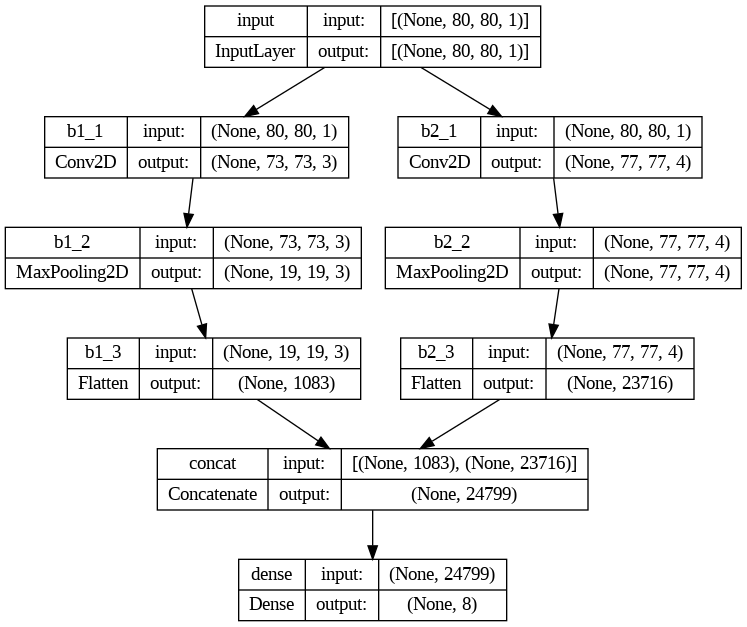

In [74]:
plot_model(network1, 'network1.png', show_shapes=True)

The figure clearly displays the two branches, with appropriate naming of the respective Conv2D, MaxPooling and Flatten Layers.

In [75]:
# Running Network1
n_epochs = 50
# bs = 128

# Compile the model
network1.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.01),
              metrics=['accuracy'])

# Train the model for 10 epochs
history = network1.fit(train_dataset_batch,
                    epochs=n_epochs,
                    # batch_size=bs,
                    validation_data=val_dataset_batch)

Epoch 1/50
75/75 [==============================] - 2s 17ms/step - loss: 1.6149 - accuracy: 0.4712 - val_loss: 1.1795 - val_accuracy: 0.5537
Epoch 2/50
75/75 [==============================] - 1s 15ms/step - loss: 1.0640 - accuracy: 0.6154 - val_loss: 1.0086 - val_accuracy: 0.6246
Epoch 3/50
75/75 [==============================] - 1s 15ms/step - loss: 0.9054 - accuracy: 0.6724 - val_loss: 0.9152 - val_accuracy: 0.6683
Epoch 4/50
75/75 [==============================] - 1s 16ms/step - loss: 0.7990 - accuracy: 0.7083 - val_loss: 0.8586 - val_accuracy: 0.6883
Epoch 5/50
75/75 [==============================] - 2s 20ms/step - loss: 0.7200 - accuracy: 0.7397 - val_loss: 0.8320 - val_accuracy: 0.6954
Epoch 6/50
75/75 [==============================] - 1s 15ms/step - loss: 0.6694 - accuracy: 0.7582 - val_loss: 0.7967 - val_accuracy: 0.7121
Epoch 7/50
75/75 [==============================] - 1s 15ms/step - loss: 0.6143 - accuracy: 0.7783 - val_loss: 0.7831 - val_accuracy: 0.7175
Epoch 8/50
75

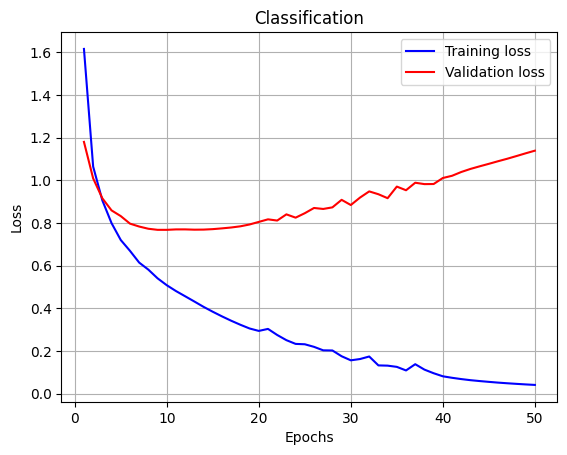

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

The model is clearly overfitting the data, as the gap between the validation and training loss is increasing after around 15 epochs. This suggests that the architecture described in the task description is too complex for the data, and that one should implement some regularization techiques such as the Dropout layer, or decrease the number of neurons in the layers. 

**Note**: For both models in P1 (and P2), I have chosen categorical crossentropy as loss function. This choice is made on the basis that this is a classification task. It meassures the dissimilarity between the predicted class probabilities by the model and the true class labels.

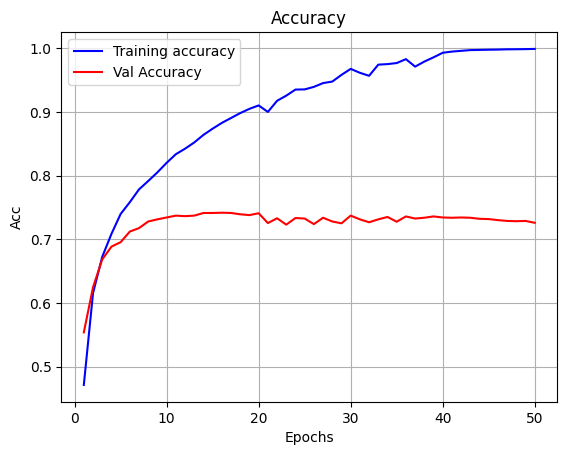

In [77]:
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']

epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Val Accuracy')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid()
plt.show()

The model quickly reaches validation accuracy above 70%. As seen in the figure one could even implement an early stopping around epoch nr. 20 as the val_acc is not increasing significantly after that. However, as the description states, I ran it for 50 epochs.

## P1.2 CNN-RNN

In [56]:
# Reduce dimensionality of the dataset
def reduce_dimension(x, y):
    return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze = val_dataset.map(reduce_dimension)

# Batch the datasets
batch_size = 128
train_dataset_batch2 = train_dataset_squeeze.batch(batch_size)
val_dataset_batch2 = val_dataset_squeeze.batch(batch_size)

In [57]:
train_dataset_batch2

<BatchDataset element_spec=(TensorSpec(shape=(None, 80, 80), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [58]:
# Define the CNN-RNN architecture
def network2():
  network2 = Sequential([
      Conv2D(filters=8, kernel_size=4, activation='relu', input_shape=(80, 80, 1)),
      MaxPooling2D(pool_size=2),
      Conv2D(filters=6, kernel_size=3, activation='relu'),
      MaxPooling2D(pool_size=2),
      Reshape((18, 18*6)),
      LSTM(128, return_sequences=True),
      LSTM(32),
      Dense(200, activation='relu'),
      Dropout(0.2),
      Dense(8, activation='softmax')
  ])
  return network2

In [59]:
network2 = network2()
print(network2.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 77, 77, 8)         136       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 38, 38, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 36, 36, 6)         438       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 18, 18, 6)        0         
 g2D)                                                            
                                                                 
 reshape_6 (Reshape)         (None, 18, 108)           0         
                                                                 
 lstm_16 (LSTM)              (None, 18, 128)          

In [60]:
n_epochs = 50

# Compile model
network2.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history2 = network2.fit(train_dataset_batch2, epochs=n_epochs, validation_data=val_dataset_batch)

Epoch 1/50
75/75 [==============================] - 5s 31ms/step - loss: 2.0542 - acc: 0.2119 - val_loss: 2.0344 - val_acc: 0.2387
Epoch 2/50
75/75 [==============================] - 2s 28ms/step - loss: 2.0025 - acc: 0.2502 - val_loss: 1.9888 - val_acc: 0.2467
Epoch 3/50
75/75 [==============================] - 3s 35ms/step - loss: 1.9568 - acc: 0.2531 - val_loss: 1.9478 - val_acc: 0.2504
Epoch 4/50
75/75 [==============================] - 2s 21ms/step - loss: 1.9149 - acc: 0.2641 - val_loss: 1.9127 - val_acc: 0.2592
Epoch 5/50
75/75 [==============================] - 2s 21ms/step - loss: 1.8822 - acc: 0.2772 - val_loss: 1.8816 - val_acc: 0.2692
Epoch 6/50
75/75 [==============================] - 2s 21ms/step - loss: 1.8508 - acc: 0.2930 - val_loss: 1.8545 - val_acc: 0.2829
Epoch 7/50
75/75 [==============================] - 2s 20ms/step - loss: 1.8239 - acc: 0.3007 - val_loss: 1.8301 - val_acc: 0.2937
Epoch 8/50
75/75 [==============================] - 3s 38ms/step - loss: 1.8038 - a

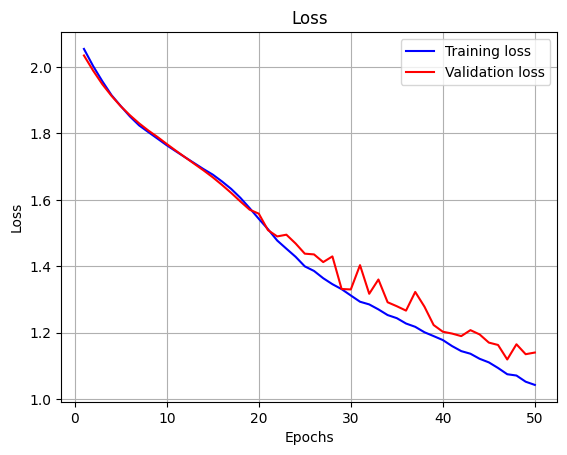

In [61]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

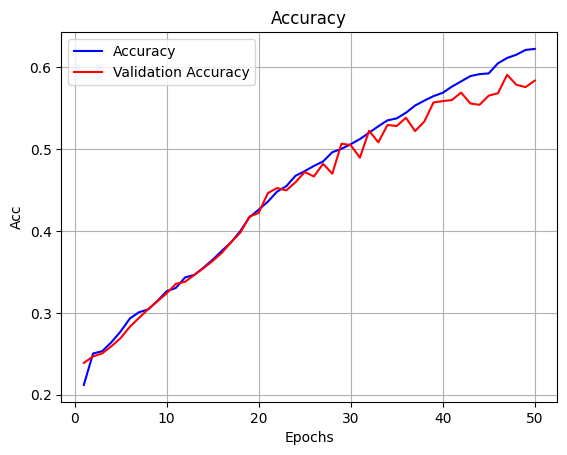

In [62]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, acc, 'b', label='Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid()
plt.show()

As seen with both the loss function and the accuracy, it has a somewhat untraditional curvature as it resembles almost a linear graph. 

However, for the accuracy, one can see that it starts its decrease, especially the validation accuracy. Based on the graph it can be argued that validation accuracy would stabalize around 60% if the model was trained for more than the 50 epochs stated as a requirement in the task description.

# P2 - Higher Accuracy of Model

There are intentionally minimal comments in the code of this architecture. See text below for explonation and justification of architecture.

In [64]:
def network8(): # number 8 indicates previous models used for exploration
    model8 = Sequential([
        # 3 Sets of Conv2D layers with increased number of neurons,
        # followed by regularization techiques
        Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(80, 80, 1)),
        Conv2D(filters=32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=3, activation='relu'),
        Conv2D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Dropout(0.4),

        Conv2D(filters=128, kernel_size=3, activation='relu'),
        Conv2D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2),
        Dropout(0.4),

        #Flatten before Dense layer
        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),

        # Add a new time dimension
        Reshape((-1, 128)),

        # Use a Bidirectional LSTM layer followed by a single LSTM layer
        Bidirectional(LSTM(64, return_sequences=True)),
        LSTM(32),

        Dense(8, activation='softmax')
    ])

    opt = Adam(lr=0.0005)
    model8.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model8


In [46]:
model8 = network8()
history8 = model8.fit(train_dataset_batch,
                    validation_data=val_dataset_batch,
                    epochs=50,
                    batch_size=32)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


75/75 [==============================] - 13s 103ms/step - loss: 2.3818 - accuracy: 0.3177 - val_loss: 3.1877 - val_accuracy: 0.1196
Epoch 2/50
75/75 [==============================] - 7s 92ms/step - loss: 1.8266 - accuracy: 0.4736 - val_loss: 3.9783 - val_accuracy: 0.1317
Epoch 3/50
75/75 [==============================] - 6s 85ms/step - loss: 1.5388 - accuracy: 0.5709 - val_loss: 3.8032 - val_accuracy: 0.1967
Epoch 4/50
75/75 [==============================] - 7s 89ms/step - loss: 1.3404 - accuracy: 0.6294 - val_loss: 3.2409 - val_accuracy: 0.2221
Epoch 5/50
75/75 [==============================] - 6s 84ms/step - loss: 1.2114 - accuracy: 0.6773 - val_loss: 3.3296 - val_accuracy: 0.2096
Epoch 6/50
75/75 [==============================] - 7s 89ms/step - loss: 1.1178 - accuracy: 0.7027 - val_loss: 2.3120 - val_accuracy: 0.3775
Epoch 7/50
75/75 [==============================] - 7s 90ms/step - loss: 1.0117 - accuracy: 0.7453 - val_loss: 1.7463 - val_accuracy: 0.5200
Epoch 8/50
75/75 [====

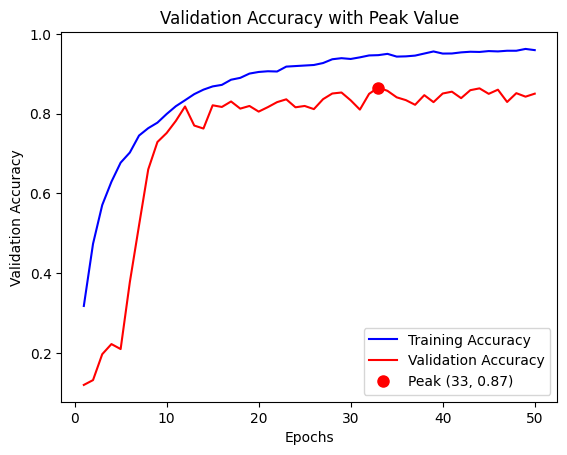

In [51]:
def plot_with_peak(history):
    val_acc = history8.history['val_accuracy']
    acc = history8.history['accuracy']
    epochs = range(1, len(val_acc) + 1)

    # Find the epoch with the highest validation accuracy
    peak_epoch = epochs[val_acc.index(max(val_acc))]
    peak_value = max(val_acc)

    # Create the line chart
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    
    # Highlight the peak
    plt.plot(peak_epoch, peak_value, marker='o', markersize=8, linestyle='None', color='red', label=f'Peak ({peak_epoch}, {peak_value:.2f})')
    
    # Set labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy with Peak Value')
    plt.legend()

    plt.show()

# Plot the line chart with the peak value
plot_with_peak(history8)

As we can see, the validation accuracy rises rapidly and sets off above 80% fairly early.

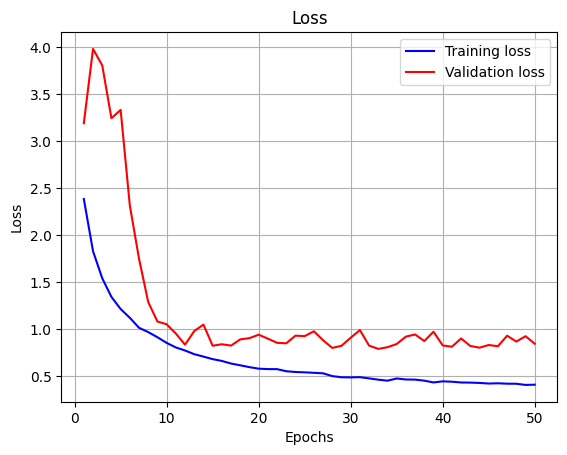

In [54]:
loss = history8.history['loss']
val_loss = history8.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [52]:
# Evaluating to get final results
results = model8.evaluate(val_dataset_batch)
print('Val Loss', results[0])
print('Val Acc', results[1])

19/19 [==============================] - 1s 24ms/step - loss: 0.8425 - accuracy: 0.8504
Val Loss 0.8424723148345947
Val Acc 0.8504166603088379


### Comments and Justification of model

I initially started out with an architecture that was fairly similar to what is presented in P1.2, consisting of a combination of Conv2D layers followed by MaxPooling2D and Dropout layers in combination with Flatten, Dense and LSTM layers. This model performed respectively good but did not get above 81% accuracy, despite tuning hyperparameters. 

Then, I explored with adding some more Dropout layers in order to slightly reduce the complexity and decrease the number of neurons in the Dense and LSTM layers. Also did more regularization work by trying out L2 regularization. This improved performance slightly. 

Lastly, to get the more significant increase in validation accuracy I decided to increase the depth of the convolutional layers. Additionally, I added Batch Normalization layers after the Conv2D layers to help with faster convergence. Additionally, I modified the RNN-part of the network by adding a Bidirectional LSTM layer followed by a single LSTM layer. 

I also adjusted hyperparameters during exploration. I found that Adam was the optimizer working the best with a rather small learning rate at 0.0005. For learning rate, I explored with values in the range of 0.01, 0.001 and 0.005. 

This ended up in the following architecture: 
*   Conv2D layers in three sets, each with 32, 64, and 128 filters. Another Conv2D layer with the same number of filters follows each layer. These layers oversee removing regional characteristics from the Mel spectrograms. 
*   After each pair of Conv2D layers, add batch-normalization layers to speed up convergence. 
*   For every pair of Conv2D layers, down sample the feature maps using MaxPooling2D layers with a pool size of 2. 
*   Dropout layers at rates of 0.3, 0.4, and 0.4, respectively, to lessen overfitting. 
*   A Flatten layer to transform the 3D feature maps into 1D feature vectors 
*   2 Dense layers followed by L2 regularization to reduce overfitting
*   Reshape Layer to add new time dimension, making it compatible with LSTM layers (RNN part). 
*   Bidirectional LSTM layer, followed by a single LSTM layer which allows the model to capture both backward and forward dependencies in the data. This has the potential to improving the model’s ability to learn temporal features. 
*   Last, a Dense output layer with 8 units and a SoftMax activation function to create the probability distribution of the 8 genres. 

The main rationale behind the model, and the main difficulty I experienced is to balance the model’s ability to learn the patterns in the Mel spectrograms while mitigating overfitting. By choosing an architecture containing of both convolutional and recurrent layers (LSTM) allows for a more versatile model. (1) Convolutional layers are good at extracting local features and are beneficial at identifying the patterns in the Mel spectrograms. (2) LSTM layers are designed to capture temporal dependencies. This is beneficial when dealing with time-series data such as audio signals. This makes the model remember longer-term patterns. (3) The combination of RNN and CNN can increase flexibility and allow the model to adapt to different types of input data more effectively. 

With regards to potential risks of the architecture, it is worth mentioning gradient problems given the use of CNNs and RNNs. If the convolutional architecture becomes too deep, there is a risk of the gradients vanishing (becoming very small during backpropagation). However, it should not be a considerable concern with this architecture. On the other hand, LSTM layers are designed to mitigate this problem due to the gating mechanisms. As with exploding gradients, the risk of it in LSTM layers is fairly low. The same should be said for convolutional layers.